In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import risktools.metrics as rm
%matplotlib inline

In [2]:
pr = pd.read_excel('fut_prices.xlsx')

In [3]:
pr.head()

code       date  PX_OPEN  PX_HIGH  PX_LOW  PX_LAST
0  URA Curncy 2015-07-01    56900    57183   56368    56979
1  URA Curncy 2015-07-02    56995    57375   56717    56858
2  URA Curncy 2015-07-03    56844    57360   56669    57263
3  URA Curncy 2015-07-06    57300    58032   57165    57942
4  URA Curncy 2015-07-07    57953    59076   57827    58786

Доходности

In [4]:
for ticker in pr.code.unique():
    ix = pr[pr.code==ticker].index
    pr.ix[ix, 'returns1d'] = rm.returns(pr.ix[ix, 'PX_LAST'])
    pr.ix[ix, 'returns2d'] = rm.returns(pr.ix[ix, 'PX_LAST'], 2)

In [5]:
pr.head()

code       date  PX_OPEN  PX_HIGH  PX_LOW  PX_LAST  returns1d  \
0  URA Curncy 2015-07-01    56900    57183   56368    56979        NaN   
1  URA Curncy 2015-07-02    56995    57375   56717    56858  -0.002124   
2  URA Curncy 2015-07-03    56844    57360   56669    57263   0.007123   
3  URA Curncy 2015-07-06    57300    58032   57165    57942   0.011858   
4  URA Curncy 2015-07-07    57953    59076   57827    58786   0.014566   

   returns2d  
0        NaN  
1        NaN  
2   0.004984  
3   0.019065  
4   0.026597

Берем двухдневные доходности

In [6]:
ret = pr.pivot('date', 'code', 'returns2d').dropna()

In [7]:
ret.head()

code        URA Curncy  VEA Index  XMCA Index
date                                         
2015-07-03    0.004984  -0.012260   -0.007629
2015-07-06    0.019065  -0.032347   -0.012955
2015-07-07    0.026597  -0.033881   -0.008303
2015-07-08    0.015239  -0.029107   -0.015287
2015-07-09   -0.004950   0.006019    0.000310

In [8]:
ret.columns = ['USD', 'RTS', 'MIX']
ret.head()

USD       RTS       MIX
date                                    
2015-07-03  0.004984 -0.012260 -0.007629
2015-07-06  0.019065 -0.032347 -0.012955
2015-07-07  0.026597 -0.033881 -0.008303
2015-07-08  0.015239 -0.029107 -0.015287
2015-07-09 -0.004950  0.006019  0.000310

Базовое предположение: Индекс РТС - это индекс майсекса, выраженный в баксах:

$$P_{RTS} = \frac {P_{MIX}}{P_{USD}} $$

$$ P_{MIX}(1+R_{MIX}) = P_{RTS}(1+R_{RTS})P_{USD}(1+R_{USD}) $$

$$ (1+R_{RTS})(1+R_{USD}) - 1+R_{MIX}  = 0 $$

Т.к. имеем дело с фьючами, чья доходность не повторяет доходность спота, вводим ограничение:

$$ \lvert(1+R_{RTS})(1+R_{USD}) - 1+R_{MIX}\rvert < c $$

Строим синтетический инструмент, как описанную разницу

In [9]:
ret['RTSUSD'] = (1 + ret['RTS']) * (1 + ret['USD'])

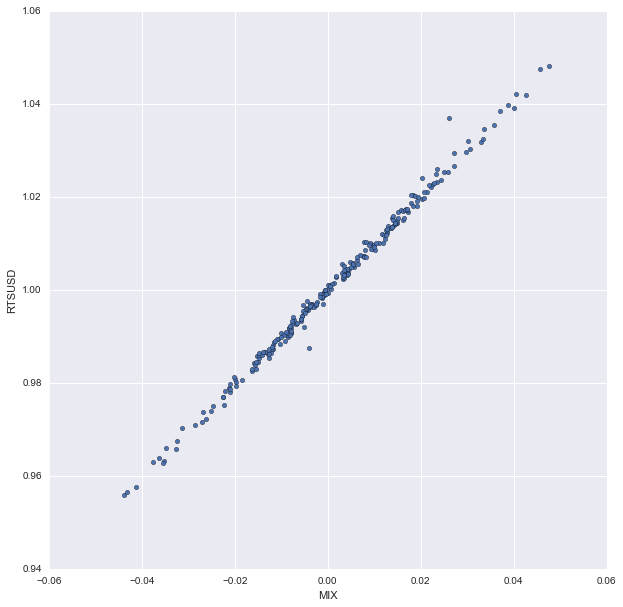

In [10]:
ret.plot(kind='scatter', x='MIX', y='RTSUSD', figsize=(10,10))

In [11]:
ret['synt'] = (1 + ret['RTS']) * (1 + ret['USD']) - (1 + ret['MIX'])

In [12]:
ret.head()

USD       RTS       MIX    RTSUSD      synt
date                                                        
2015-07-03  0.004984 -0.012260 -0.007629  0.992663  0.000292
2015-07-06  0.019065 -0.032347 -0.012955  0.986102 -0.000943
2015-07-07  0.026597 -0.033881 -0.008303  0.991814  0.000117
2015-07-08  0.015239 -0.029107 -0.015287  0.985688  0.000976
2015-07-09 -0.004950  0.006019  0.000310  1.001039  0.000728

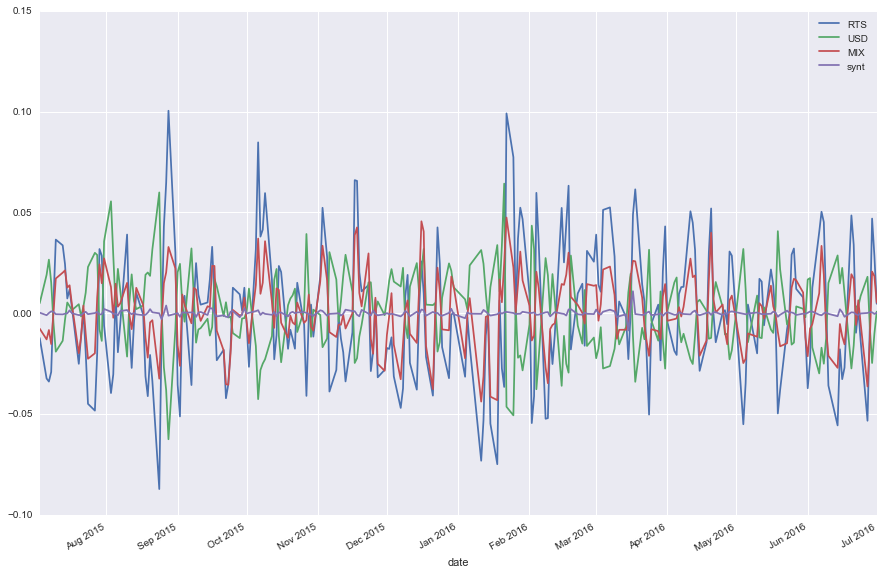

In [13]:
ret[['RTS', 'USD', 'MIX', 'synt']].plot(figsize=(15,10))

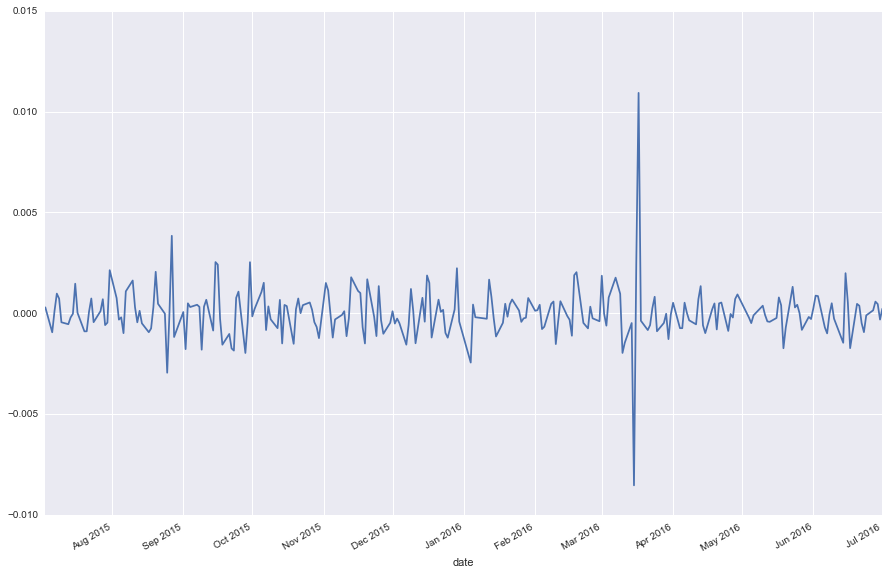

In [14]:
ret['synt'].plot(figsize=(15,10))

Определяем размер базового ограничения как 99,9% VAR:

In [15]:
c = rm.hvar(ret['synt'])
c

0.005